---
## STEP 0: LOAD LIBRARIES AND DATA
---

In [55]:
# for saving the report to file
from pathlib import Path
import os

# visualize
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import umap.plot
import hdbscan
# REQUIREMENTS: umap.plot requires matplotlib, datashader, colorcet and holoviews to be installed

# Used to get the data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def hd_resolution_categorizer(df):
    
    """


    Parameters
    ----------
    df : Pandas Data Frame
        the dataframe containing the features
    
    Returns
    -------
    Pandas Data Frame

    """
    
    
    if df['resolution_string'] in ["2304x1440", "2560x1600", "2880x1800"]:
        return 'retina'
    elif df['pixels_x'] >= 1200 and df['pixels_x'] <= 1600:
        return 'hd'
    elif df['pixels_x'] == 1920:
        return 'fullhd'
    elif df['pixels_x'] > 1920 and df['pixels_x'] < 3840:
        return 'qhd/uhd'
    elif df['pixels_x'] == 3840:
        return '4k'
    else:
        return 'sd'
    
def ssd_categorizer(df):
    
    """


    Parameters
    ----------
    df : Pandas Data Frame
        the dataframe containing the features
    
    Returns
    -------
    Pandas Data Frame

    """
    
    if df['ssd'] == 0:
        return 'none'
    elif df['ssd'] < 64:
        return 'small'
    elif df['ssd'] <= 256:
        return 'medium'
    else:
        return 'large'
    

def storage_categorizer(df):
    
    """


    Parameters
    ----------
    df : Pandas Data Frame
        the dataframe containing the features
    
    Returns
    -------
    Pandas Data Frame

    """
    
    if df['storage'] == 0:
        return "none"
    elif df['storage'] <= 256:
        return 'small'
    elif df['storage'] <= 1028:
        return 'medium'
    elif df['storage'] <= 2056:
        return 'large'
    else:
        return 'very large'
    
    
# set relative to cwd from os.getcwd()
DATA_PATH = '../../../data/'


In [6]:
os.getcwd()

'C:\\Users\\VictorGueorguiev\\OneDrive - Amplify Analytix\\Documents\\University\\Advanced Analytics for Business\\AAForB_Assignment2\\code\\Victor\\exploratory_analysis'

---
## STEP 1: LOAD DATA
---

In [7]:
# load data using pandas
df_laptops = pd.read_csv(DATA_PATH + 'train.csv')

In [8]:
print('INFO Number of train instances/data points: ' + str(df_laptops.shape[0]))
print('INFO Number of train features/variables: ' + str(df_laptops.shape[1]))

INFO Number of train instances/data points: 510
INFO Number of train features/variables: 22


In [8]:
df_laptops.dtypes

id                       int64
name                    object
brand                   object
base_name               object
screen_size            float64
pixels_x                 int64
pixels_y                 int64
screen_surface          object
touchscreen              int64
cpu                     object
cpu_details             object
detachable_keyboard    float64
discrete_gpu             int64
gpu                     object
os                      object
os_details              object
ram                      int64
ssd                      int64
storage                  int64
weight                 float64
min_price              float64
max_price              float64
dtype: object

---
## STEP 2: Compute Features 
---

Do feature engineering of features we believe to be useful for modelling later on


### 2.1: HD RESOLUTION CATEGORY
---


In [56]:

# Categorize the screen resolution into specific categories such as HD, FullHD, 4K, etc.
df_laptops['resolution_string'] = df_laptops['pixels_x'].astype(str) + 'x' + df_laptops['pixels_y'].astype(str)
df_laptops['hd_resolution_category'] = df_laptops.apply(hd_resolution_categorizer, axis = 1)

---
### 2.2: SSD CATEGORY
---

In [57]:
# Categorize the SSD size into specific categories such as Small, Medium and Large, etc.
df_laptops['ssd_category'] = df_laptops.apply(ssd_categorizer, axis = 1)


---
### 2.3: STORAGE CATEGORY
---

In [58]:
# Categorize the main storage size into specific categories such as Small, Medium and Large, etc.
df_laptops['storage_category'] = df_laptops.apply(storage_categorizer, axis = 1)


---
### 2.4: CPU FREQUENCY
---

In [60]:
df_laptops['cpu_frequency'] = df_laptops['cpu_details'].str.extract(r'\s*([0-9].[0-9][0-9])\s*[gG][hH][zZ]')
df_laptops['cpu_frequency2'] = df_laptops['cpu_details'].str.extract(r'\s*([0-9].[0-9])\s*[gG][hH][zZ]')

df_laptops['cpu_frequency'] = df_laptops['cpu_frequency'].replace(np.nan, '0')
df_laptops['cpu_frequency2'] = df_laptops['cpu_frequency2'].replace(np.nan, '0')

df_laptops['cpu_frequency'] = df_laptops['cpu_frequency'].astype(float)
df_laptops['cpu_frequency2'] = df_laptops['cpu_frequency2'].astype(float)
df_laptops['cpu_frequency'] = df_laptops['cpu_frequency'] + df_laptops['cpu_frequency2']

df_laptops = df_laptops.assign(cpu_frequency = [a if a > 0.0 else np.nan for a in df_laptops['cpu_frequency']])
df_laptops = df_laptops.drop(['cpu_frequency2'], axis = 1)

---
## STEP 3: Exploratory Analysis
---

Looking at the distributions of max and min laptop prices across the defined categories and features. Do the defined features make sense to be exploited in our model?

Text(0.5, 0.98, 'Distribution of Min Price across Brand and whether there is a discrete GPU\n')

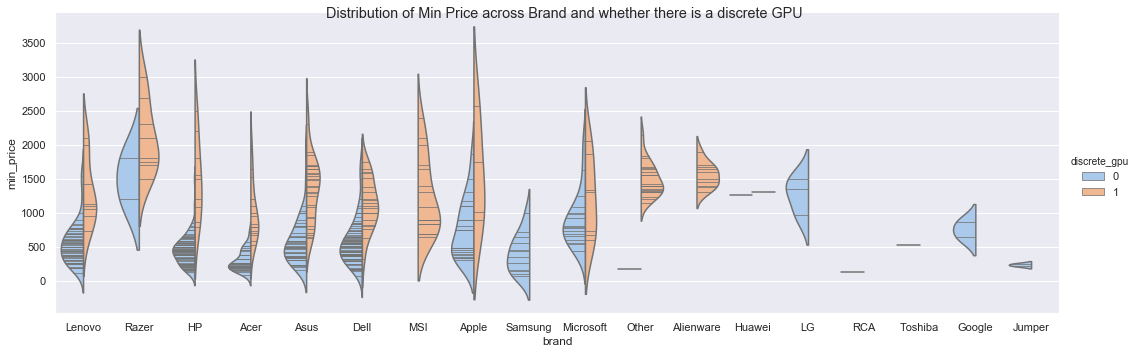

In [70]:
sns.set(rc={'figure.figsize':(80,30)})

g = sns.catplot( x="brand", y="min_price", hue="discrete_gpu",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across Brand and whether there is a discrete GPU\n")


Text(0.5, 0.98, 'Distribution of Min Price across detachable keyboard and whether there is a discrete GPU\n')

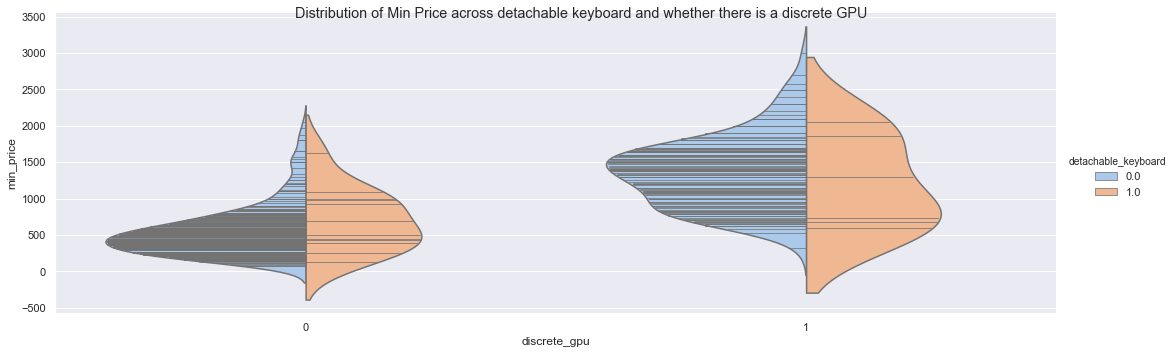

In [69]:
g = sns.catplot(x="discrete_gpu", y="min_price", hue="detachable_keyboard",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across detachable keyboard and whether there is a discrete GPU\n")


Text(0.5, 0.98, 'Distribution of Min Price across Touchscreens and whether there is a discrete Keyboard\n')

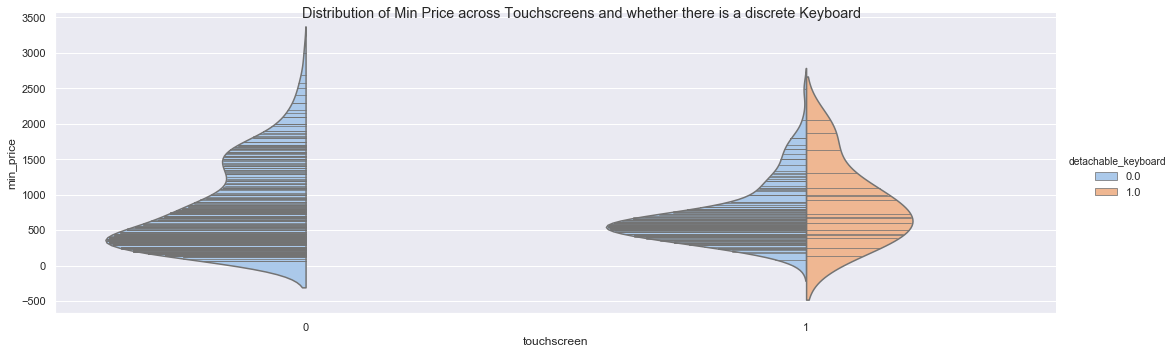

In [68]:
g = sns.catplot(x="touchscreen", y="min_price", hue="detachable_keyboard",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across Touchscreens and whether there is a discrete Keyboard\n")


Text(0.5, 0.98, 'Distribution of Min Price across OS and whether there is a discrete GPU\n')

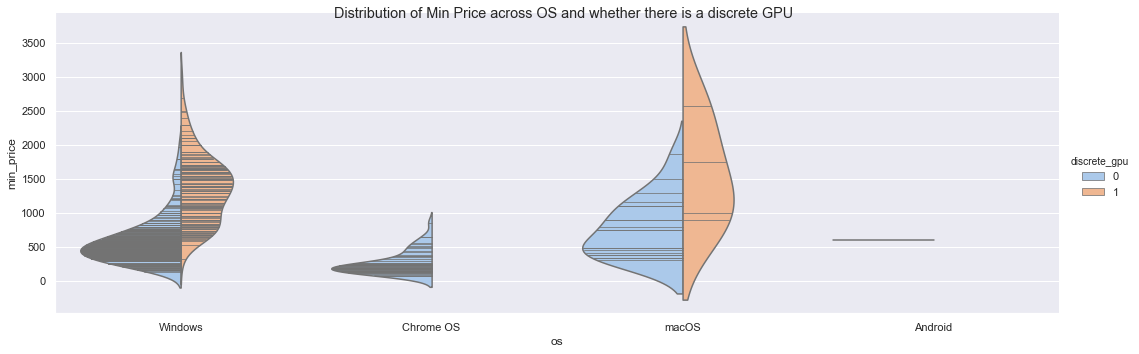

In [67]:
g = sns.catplot(x="os", y="min_price", hue = "discrete_gpu",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across OS and whether there is a discrete GPU\n")


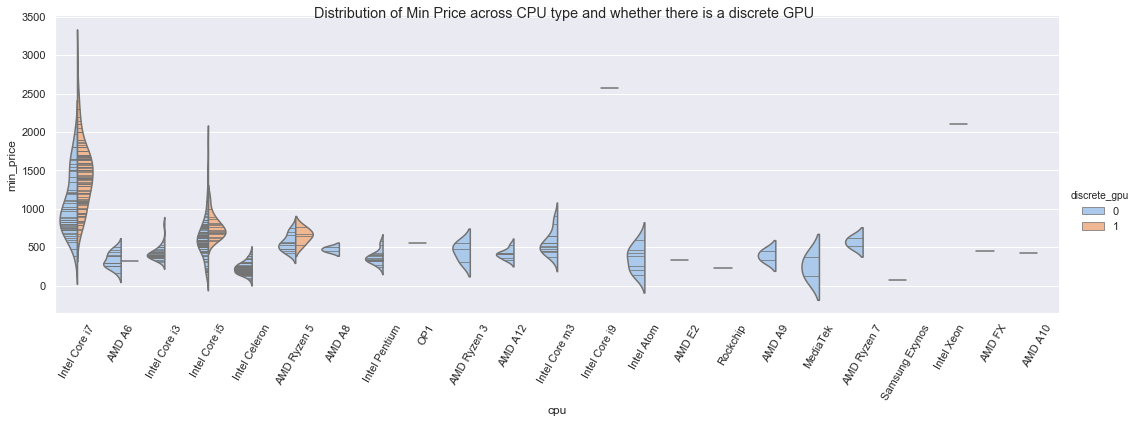

In [66]:
g = sns.catplot(x="cpu", y="min_price", hue = "discrete_gpu",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across CPU type and whether there is a discrete GPU\n")
g.set_xticklabels(rotation=60)

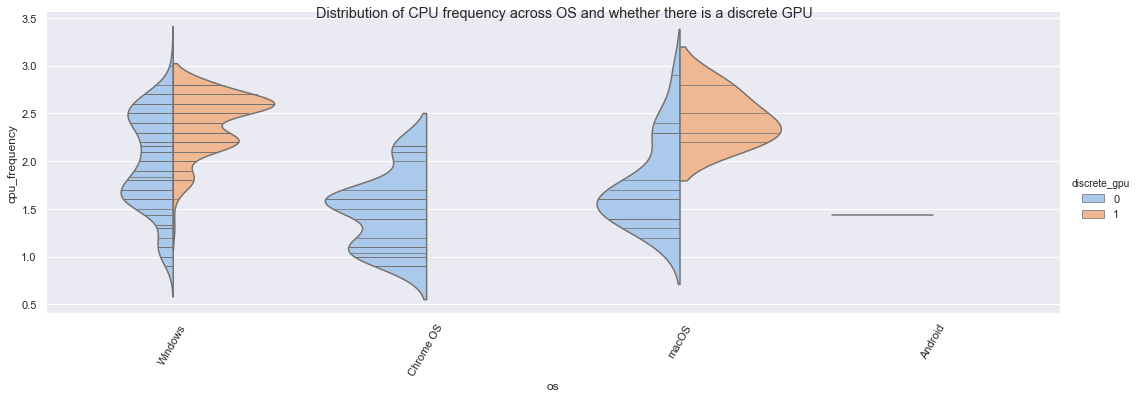

In [65]:
g = sns.catplot(x="os", y="cpu_frequency", hue = "discrete_gpu",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of CPU frequency across OS and whether there is a discrete GPU\n")
g.set_xticklabels(rotation=60)

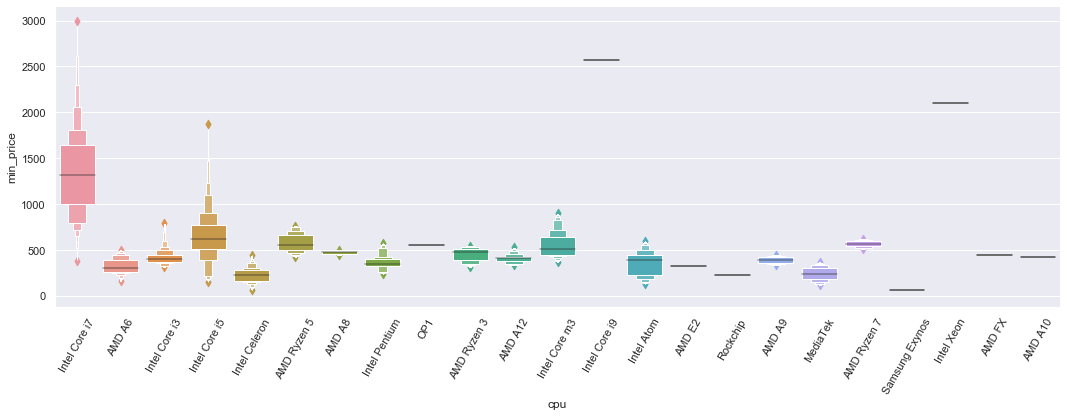

In [23]:
g = sns.catplot(x="cpu", y="min_price", kind="boxen",
            data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.set_xticklabels(rotation=60)

Text(0.5, 0.98, 'Distribution of Min Price across HD category and whether there is a discrete GPU\n')

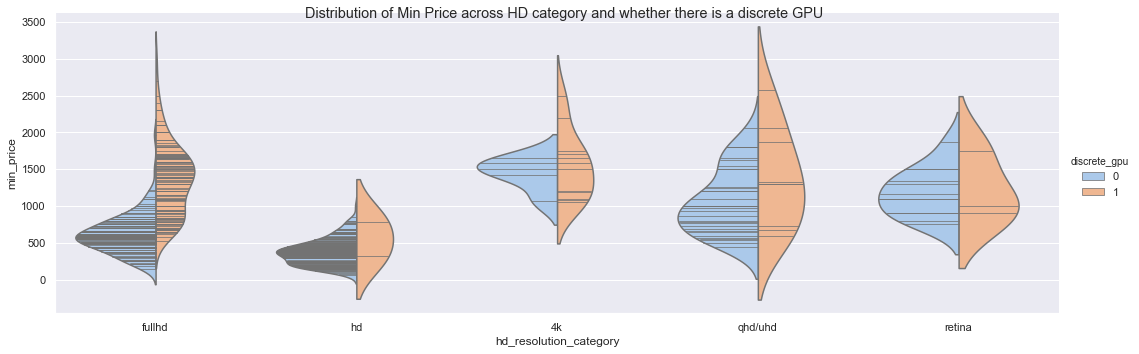

In [72]:
g = sns.catplot(x="hd_resolution_category", y="min_price", hue="discrete_gpu",
            kind="violin", inner="stick", split=True,
            palette="pastel", data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.fig.suptitle("Distribution of Min Price across HD category and whether there is a discrete GPU\n")


Text(0.5, 0.98, 'Distribution of Min Price across SSD category\n')

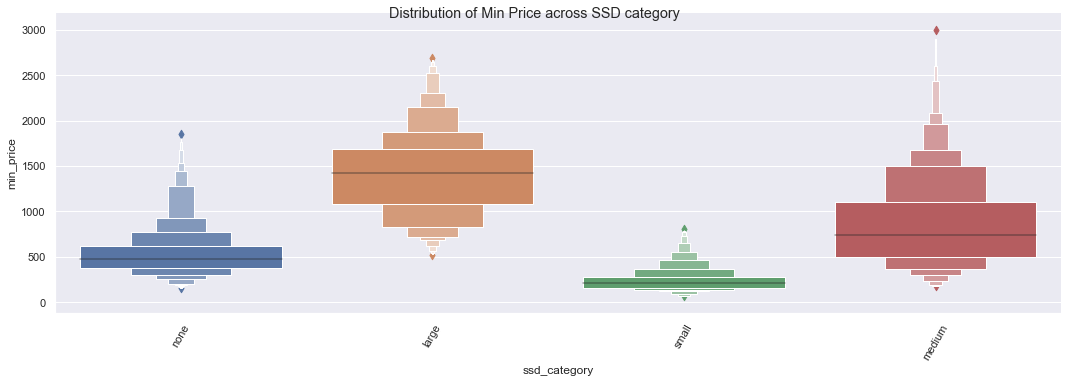

In [76]:
g = sns.catplot(x="ssd_category", y="min_price", kind="boxen",
            data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.set_xticklabels(rotation=60)
g.fig.suptitle("Distribution of Min Price across SSD category\n")


Text(0.5, 0.98, 'Distribution of Min Price across Storage category\n')

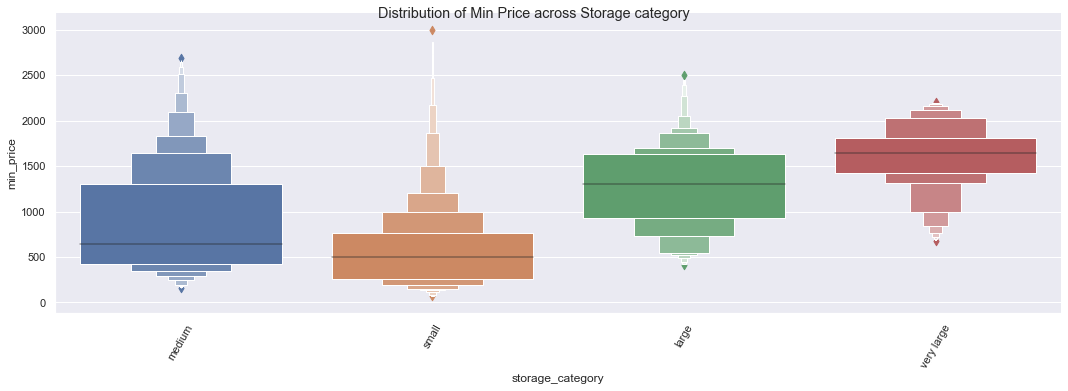

In [77]:
g = sns.catplot(x="storage_category", y="min_price", kind="boxen", 
            data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.set_xticklabels(rotation=60)
g.fig.suptitle("Distribution of Min Price across Storage category\n")


Text(0.5, 0.98, 'Distribution of Min Price across Storage category\n')

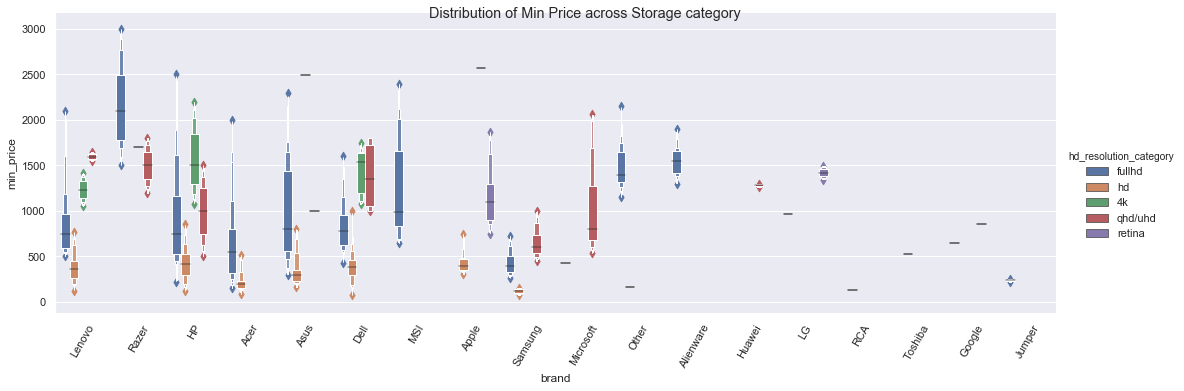

In [78]:
g = sns.catplot(x="brand", y="min_price", kind="boxen", hue="hd_resolution_category",
            data=df_laptops,
            height=5, # make the plot 5 units high
            aspect=3); # height should be three times width
g.set_xticklabels(rotation=60)
g.fig.suptitle("Distribution of Min Price across Storage category\n")


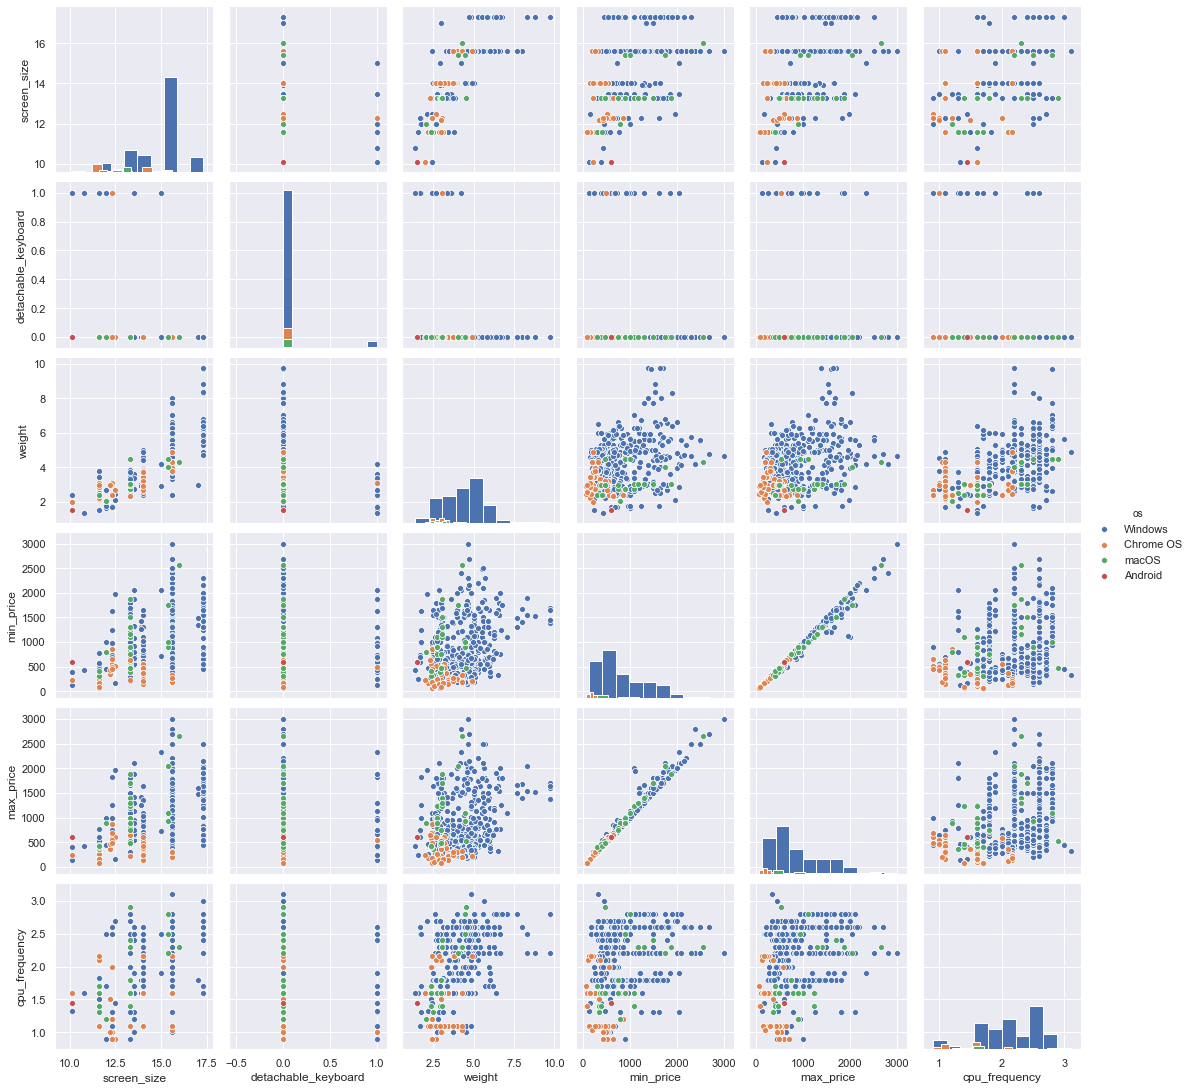

In [61]:
df_laptops_numericals = df_laptops.select_dtypes(include = ['float64'])
df_laptops_numericals = pd.concat([df_laptops_numericals, df_laptops['os']], axis = 1)
sns.pairplot(df_laptops_numericals, hue = "os", diag_kind = 'hist');

---
## STEP 4: Dimensionality Reduction
---
Using dimensionality reduction from UMAP to embed our space into 2D and visualize it more easily. In principle, UMAP is more stable that other visualization techniques such as TSNE and hence can also be used as feature transformation to include new numerical features into a regression model.

In our case, we use this on the CPU details and Base Name fields to visualize them more succinctly, as these fields are most complex in the dataset and harder to mine for features than any other fields.

For CPU details we can immediately see some interesting knowledge, how UMAP clusters upper tier CPUs together, as well as clustering AMD and Intel CPUs separately and within their own higher tier categories.

The same goes for Base Name: More expensive brands and notebooks, gaming laptops and the like are all clustered together. Perhaps using UMAP output as features is not out of the question. A 3D representation from UMAP would potentially boost performance and keep the model fairly generalizable

C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


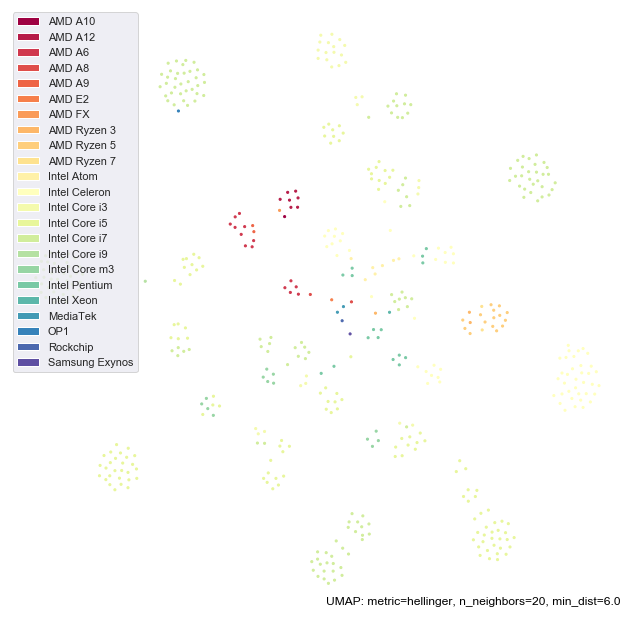

In [26]:
### CPU DETAILS AND HDBSCAN CLUSTERING

base_names = df_laptops[['cpu', 'cpu_details']].dropna()
tfidf_vectorizer = TfidfVectorizer(min_df=3, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(base_names.cpu_details, y=base_names.cpu)
tfidf_embedding = umap.UMAP(n_neighbors = 20, metric='hellinger', min_dist = 6.0, spread = 15.0, random_state = 0).fit(tfidf_word_doc_matrix)
fig = umap.plot.points(tfidf_embedding, labels=base_names.cpu)
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


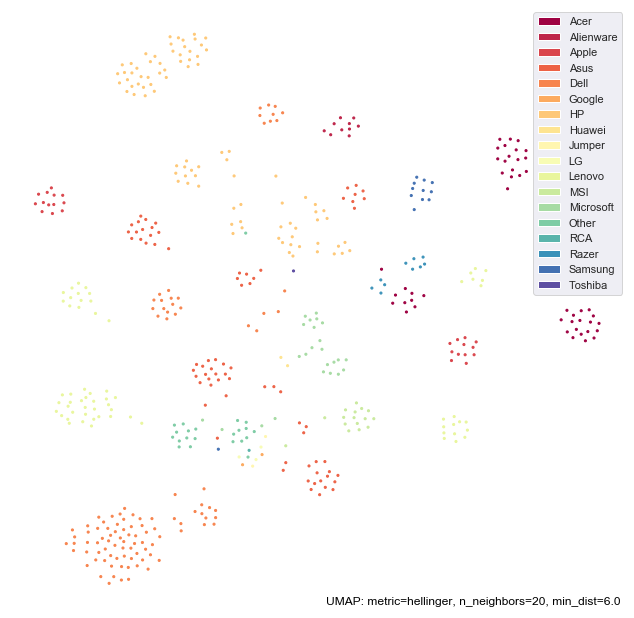

In [27]:

### BASE NAMES EMBEDDING AND HDBSCAN CLUSTERING
base_names = df_laptops[['base_name', 'brand']]
tfidf_vectorizer = TfidfVectorizer(min_df=5, stop_words='english')
tfidf_word_doc_matrix = tfidf_vectorizer.fit_transform(base_names.base_name, y = base_names.brand)
tfidf_embedding = umap.UMAP(n_neighbors = 20, metric='hellinger', min_dist = 6.0, spread = 15.0, random_state = 0).fit(tfidf_word_doc_matrix)
fig = umap.plot.points(tfidf_embedding, labels=base_names.brand)
plt.show()



C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
C:\ProgramData\Anaconda3\lib\site-packages\umap\umap_.py:1157: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


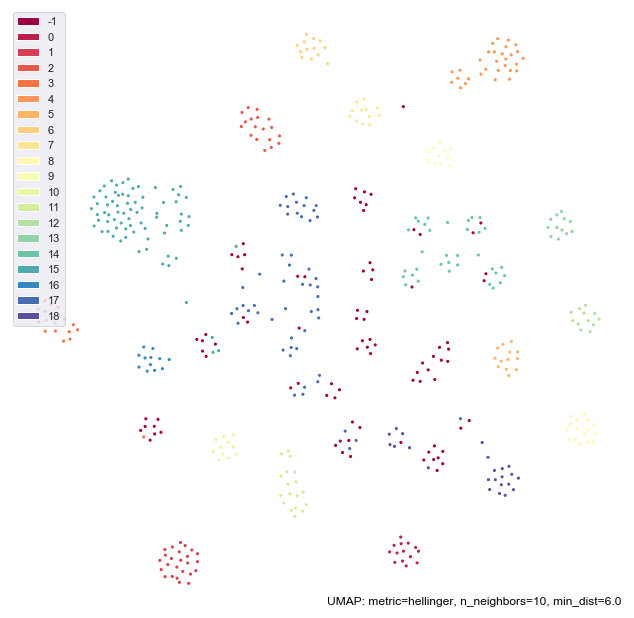

In [52]:
tfidf_clusterable = umap.UMAP(n_neighbors = 10, metric='hellinger', min_dist = 6.0, spread = 15.0, random_state = 0).fit_transform(tfidf_word_doc_matrix)

labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=10,
).fit_predict(tfidf_clusterable)

clustered = (labels >= 0)
tfidf_word_doc_matrix_subset = tfidf_word_doc_matrix[~clustered]
tfidf_standard_embedding = umap.UMAP(n_neighbors = 10, metric='hellinger', min_dist = 6.0, spread = 15.0, random_state = 0).fit(tfidf_word_doc_matrix)

fig = umap.plot.points(tfidf_standard_embedding, labels=labels)
plt.show()